# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 24.11.2021

Мягкий дедлайн: 23:59MSK 07.12.2021


Жесткий дедлайн: 23:59MSK 10.12.2021

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
from sklearn.datasets import load_boston

In [4]:
boston = load_boston()

In [5]:
X = boston["data"]
y = boston["target"]

In [6]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [7]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.75418992851491

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [14]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    n = X.shape[0]
    indexes = np.arange(n)
    pred_sum = np.zeros(shape=n)
    pred_count = np.zeros(shape=n)
    pred_square = np.zeros(shape=n)
    pred_difference = np.array([])
    
    # создание бутстрапированой выборки, out-of-bag выборки,
    # обучание моделей и расчёт необходимых статистик
    for i in range(num_runs):
        bootstrapped = np.random.choice(indexes, size=n)
        out_of_bag = np.array(list(set(indexes) - set(bootstrapped)))
        regressor.fit(X[bootstrapped], y[bootstrapped])
        predictions = regressor.predict(X[out_of_bag])
        
        pred_square[out_of_bag] += predictions**2
        pred_sum[out_of_bag] += predictions
        pred_count[out_of_bag] += 1
        square_pred_diff = (y[out_of_bag] - predictions)**2
        pred_difference = np.append(pred_difference, square_pred_diff)
    
    # расчёт bias, variance для каждого x_n из X
    # используя только x_n которые попали в out-of-bag выборку
    non_zero_ind = (pred_count != 0)
    avg_pred = pred_sum[non_zero_ind] / pred_count[non_zero_ind]
    bias_x_n = (y[non_zero_ind] - avg_pred)**2
    variance_x_n = pred_square[non_zero_ind] / pred_count[non_zero_ind] - avg_pred**2
    
    # расчёт итоговых bias, variance и loss для модели
    bias_ = bias_x_n.mean()
    variance_ = variance_x_n.mean()
    loss_ = pred_difference.mean()
    
    return bias_, variance_, loss_
    

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [10]:
np.random.seed(123)

methods = {
    'Linear Regression' : LinearRegression(),
    'Decision Tree Regressor' : DecisionTreeRegressor(),
    'Random Forest Regressor' : RandomForestRegressor()
}

for method_name, estimator in methods.items():
    bias, variance, loss = compute_biase_variance(estimator, X, y)
    print(method_name + ':')
    print(f'    Bias:      %.5f' % bias)
    print(f'    Variance:  %.5f' % variance)
    print(f'    Loss:      %.5f' % loss)
    print('\n')

Linear Regression:
    Bias:      23.70315
    Variance:  0.90400
    Loss:      24.56948


Decision Tree Regressor:
    Bias:      10.42714
    Variance:  13.02414
    Loss:      23.57713


Random Forest Regressor:
    Bias:      10.67429
    Variance:  2.24333
    Loss:      12.96143




__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__ Все полученные результаты согласуются с теоретическими значниями.

У линейной модели получился высокий bias, так как линейные модели могут хорошо приближать только линейные зависимости, если здесь зависимость нелинейная, то и смещение получается высоким, так как модели не приближает истинной зависимости. Variance для линейной модели получился низкий, так и должно быть, потому что на одних и тех же данных (несмотря на то, что базовые модели строятся на бутстрапированой выборке) линейные модели получаются очень похожи между собой. А variance по сути показывает, насколько модель чувствительна к изменению обучающей выборки. Линейные модели - очень простые, поэтому они не слишком меняются с обучающей выборки, поэтому и поучается низкий variance.

Решающее дерево показало гораздо более низкое смещение (bias), чем линейная модель, так как деревья могет выучивать более сложные зависимости, чем линейные, поэтому смещение и получилось меньше. Разброс же наоборот увеличился, так как деревья - это очень неустойчивая модель по отношению к изменению обучающей выборки (при небольшом изменениеии обучающей выборки, дерево может кардинально изменить свою структуру).

Случайный лес - это бэггинг над решающими деревьями, из теории известно, что бэггинг над моделями не изменяет смещение (bias), но уменьшает разброс (variance) в N раз (N - число моделей в композиции) при условии некоррелированности базовых моделей. Но если базовые модели коррелированы, то уменьшение разброса не такое заметное. Так как в бэггинге используются бутстрапированные выборки для обучения базовых моделей, то за счёт этой случайности и свойства неустойчивости деревьев в изменению обучающей выборки поулчаем, что базовые модели имеют не слишком высокую корреляцю. Поэтому у случайного леса bias получился таким же как и у решающего дерева, а смещение уменьшилось значитально.

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__ как я уже писала выше, согласно теории, бэггинг уменьшает разброс в N раз (где N - число базовых моделей) при условии, что базовые модели некоррелированы, если же базовые модели коррелированы, то уменьшение разброса будет тем менее значительным, чем более коррелированы модели. При этом бэггинг не изменяет смещение.

In [9]:
from sklearn.ensemble import BaggingRegressor

In [15]:
methods = {
    'Linear Regression' : LinearRegression(),
    'Decision Tree Regressor' : DecisionTreeRegressor(),
    'Random Forest Regressor' : RandomForestRegressor()
}

for method_name, estimator in methods.items():
    bagging_model = BaggingRegressor(base_estimator=estimator)
    bias, variance, loss = compute_biase_variance(bagging_model,
                                                  X,
                                                  y,
                                                  num_runs=500)
    
    print('Bagging over ' + method_name + ':')
    print(f'    Bias:      %.5f' % bias)
    print(f'    Variance:  %.5f' % variance)
    print(f'    Loss:      %.5f' % loss)
    print('\n')

Bagging over Linear Regression:
    Bias:      23.75910
    Variance:  1.04232
    Loss:      24.86438


Bagging over Decision Tree Regressor:
    Bias:      10.75817
    Variance:  3.43878
    Loss:      14.19450


Bagging over Random Forest Regressor:
    Bias:      11.64115
    Variance:  1.44486
    Loss:      13.29423




В итоге, для линейных моделей разброс не изменился, так как они сильно коррелированы, следовательно, разброс не уменьшился. Смещение не изменилось.

Для случайного леса разброс уменьшился значительно, как и предполагает теория. Всё потому что деревья имеют не слишком сильно коррелированы, поэтому присутсвует эффект уменьшения разброса при использовании бэггинга. Так же стоит заметить, что бэггинг над случайными деревьями всё же не показал такого же результата как и случайный лес в задании 2, потому что случайный лес это не просто бэггинг над деревьями, там ещё присутствует рандомизация по множеству признаков для каждой из вершин каждого дерева композиции. То есть базовые модели в случайном лесе ещё менее коррелированы, поэтому в случайном лесе разброс меньше, чем для простого бэггинга над деревьями. Ну а смещение для бэггинга над деревьями не изменилось.

Для бэггинга над случайными лесами разброс так же немного уменьшился, но при этом немного увеличилось смещение. Возможно это случайность и на это можно не обращать внимания. Но с другой стороы это так же моглоа броизойти по причине того, что каждый отдельный случайный лес был недообучен, то есть параметр n_estimators по умолчанию слишком маленький для того, чтобы случайный лес мог обучиться достаточно хорошо. Поэтому тут и возникает эффект уменьшения разброса, как для композиции более слабых моделей, чем случайный лес. А увеличение смещений кроме как случайным стечением обстоятельств я не могу обосновать.

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [16]:
def plot_predictions(regressor, X, y, ax=None, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    if ax is None:
        ax = plt.gca()
    
    # формирование случайных маленьких тестовых подвыборок
    n_whole = X.shape[0]
    indexes_whole = np.arange(n_whole)
    test_ind = np.random.choice(indexes_whole, size=num_test_objects)
    train_ind = np.array(list(set(indexes_whole) - set(test_ind)))
    
    X_test = X[test_ind]
    y_test = y[test_ind]
    
    X_train = X[train_ind]
    y_train = y[train_ind]
    
    
    # бутстрап над X_train
    predictions = [] # сюда буду складывать предсказания для X_test на каждом из num_runs шагов
    n = X_train.shape[0]
    indexes = np.arange(n)
    for i in range(num_runs):
        bootstrapped = np.random.choice(indexes, size=n)
        regressor.fit(X_train[bootstrapped], y_train[bootstrapped])
        y_pred = regressor.predict(X_test)
        predictions.append(y_pred)
    
    # отрисовка графика
    objects = np.arange(y_test.shape[0])
    
    for i in range(num_runs):  # отрисовка всех предсказаний
        ax.scatter(x=objects, y=predictions[i], color='r', alpha=0.5, s=20)
    
    ax.scatter(x=objects, y=y_test, color='black', s=40)
    
    ax.set_title(title)
    ax.set_xlabel('Test objects')
    ax.set_ylabel('Predictions')
    
    return ax

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

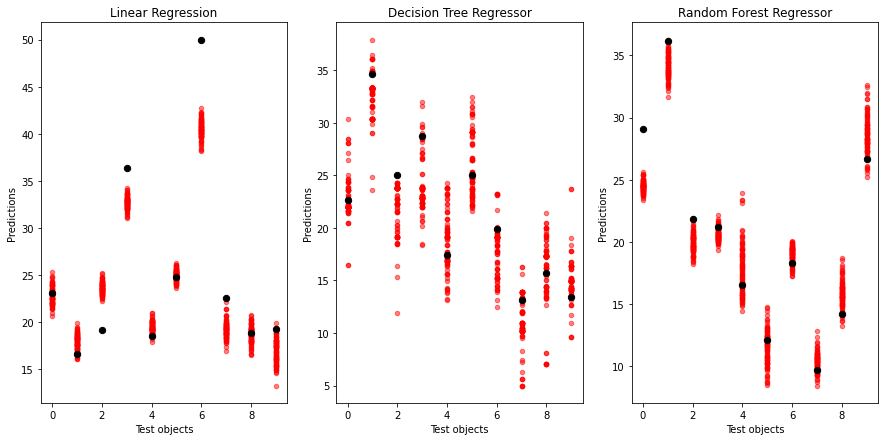

In [17]:
np.random.seed(0)

methods = [
    ('Linear Regression', LinearRegression()),
    ('Decision Tree Regressor', DecisionTreeRegressor()),
    ('Random Forest Regressor', RandomForestRegressor())
]

fig, axes = plt.subplots(1, 3)
fig.set_figheight(7)
fig.set_figwidth(15)
for i in range(3):
    plot_predictions(
        regressor=methods[i][1],
        X=X,
        y=y,
        ax=axes[i],
        num_runs=100,
        num_test_objects=10,
        title=methods[i][0]
    )

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__ Полученные результаты, опять же полуностью совпадают с теорией.

Для обычной линейной модели, видно, что среднее из всех предсказаний может иногда (на некоторых объектах) сильно отличаться от действительного предсказания, это происходит из-за большого смещений (bias) линейной модели, так как скорее всего наши данные имеют нелинейную зависимость. Разброс же (variance), наоборот, невысокий, так как все красные точки для каждого объекта хорошо достаточно близки друг к другу (скучковались вокруг одного ответа для каждого из объектов).

У решаеющего древа получился гораздо больший разброс по сравнению с линейными моделями. При разных обучающих выборках прогнозы  на некоторых объектах отличаются кардинально друг от друга. При этом смещение уменьшилось, так как все красные точки теперь группируются вокруг чоответствующей чёрной и нет таких ситуаций, когда чёрная точки и группа красных далеки дргу от дргуа как, например, получилось с седьмым объектом на первом рисунке.

У случайного леса сильно меньше разброс, чем у решающего дерева, так как точки теперь более сгруппированы вместе для каждого из объектов. По сгруппированности красных точек (то есть прогнозов на моделях, обученных на разных подвыборках) случайный лес похож на сгруппированность точек для линейной модели. Смещение же напротив, лучше чем у линейных моделей, и больше похоже а смещенеие, показанное решающим деревом.

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [18]:
bias_1 = []
variance_1 = []

for depth in list(range(1, 11)):
    bias, variance, _ = compute_biase_variance(
        regressor=DecisionTreeRegressor(max_depth=depth),
        X=X,
        y=y,
        num_runs=500
    )
    bias_1.append(bias)
    variance_1.append(variance)

In [19]:
bias_2 = []
variance_2 = []

for features in list(range(1, X.shape[1] + 1)):
    bias, variance, _ = compute_biase_variance(
        regressor=DecisionTreeRegressor(max_features=features),
        X=X,
        y=y,
        num_runs=500
    )
    bias_2.append(bias)
    variance_2.append(variance)

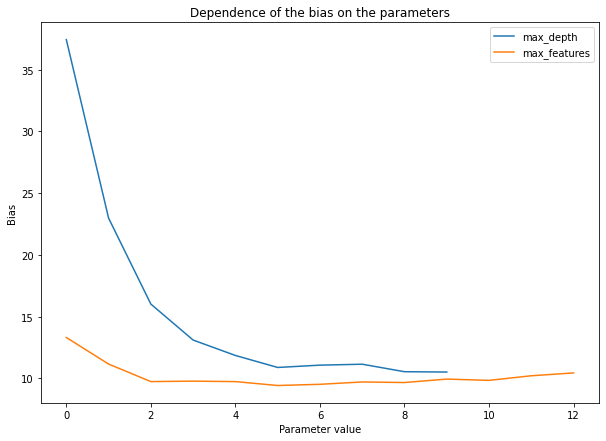

In [20]:
plt.figure(figsize=(10,7))

plt.plot(bias_1, label='max_depth')
plt.plot(bias_2, label='max_features')
plt.title('Dependence of the bias on the parameters')
plt.xlabel('Parameter value')
plt.ylabel('Bias')
plt.legend()

plt.show()

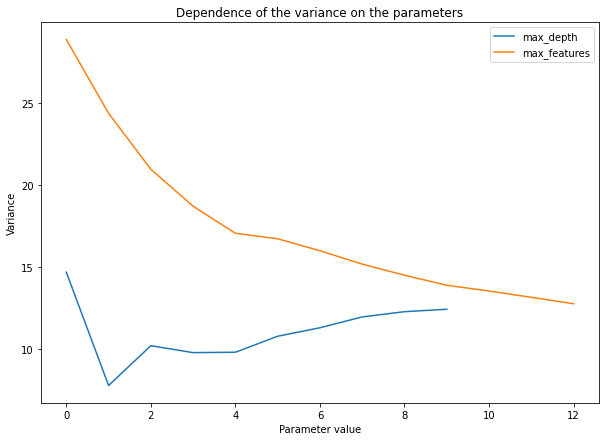

In [21]:
plt.figure(figsize=(10,7))

plt.plot(variance_1, label='max_depth')
plt.plot(variance_2, label='max_features')
plt.title('Dependence of the variance on the parameters')
plt.xlabel('Parameter value')
plt.ylabel('Variance')
plt.legend()

plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [72]:
from sklearn.ensemble import GradientBoostingClassifier

In [22]:
bias_RF = []
variance_RF = []

for estimators in 2**np.arange(1, 10):
    bias, variance, _ = compute_biase_variance(
        regressor=RandomForestRegressor(n_estimators=estimators),
        X=X,
        y=y,
        num_runs=250
    )
    bias_RF.append(bias)
    variance_RF.append(variance)

In [23]:
bias_GB = []
variance_GB = []

for estimators in 2**np.arange(1, 10):
    bias, variance, _ = compute_biase_variance(
        regressor=RandomForestRegressor(n_estimators=estimators),
        X=X,
        y=y,
        num_runs=250
    )
    bias_GB.append(bias)
    variance_GB.append(variance)

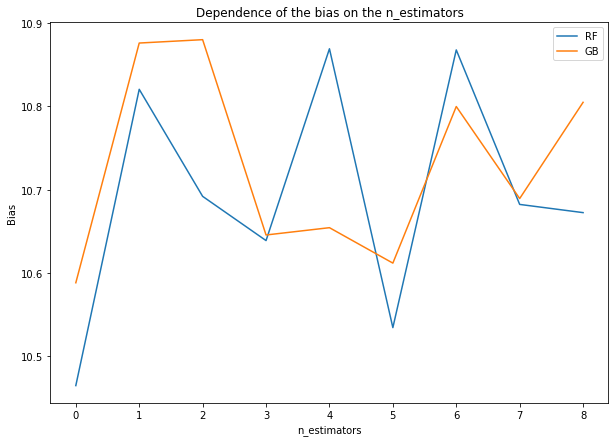

In [28]:
plt.figure(figsize=(10,7))

plt.plot(bias_RF, label='RF')
plt.plot(bias_GB, label='GB')
plt.title('Dependence of the bias on the n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Bias')
plt.legend()

plt.show()

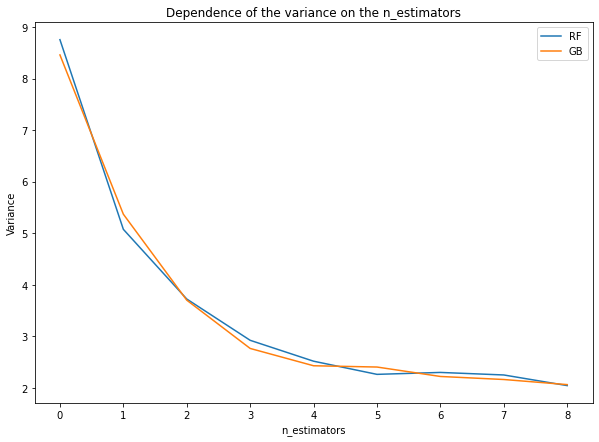

In [29]:
plt.figure(figsize=(10,7))

plt.plot(variance_RF, label='RF')
plt.plot(variance_GB, label='GB')
plt.title('Dependence of the variance on the n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Variance')
plt.legend()

plt.show()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__
По самому первому графику видно можно заметить, как смещение уменьшается при увеличении максимальной глубины дерева и это легко объяснить тем, что когда мы позволяем делать более глубокие деревья, мы даём модели возможность выучивать более сложные закономерности, а при с небольшой максимальной глубиной это сделать невозможно. При этом для параметра max_features нет такого эффекта, так как дерево строится жадно и из любого набора параметров всё равно будет выбран лучший.

На втором графику разброс уменьшается при увеличении max_features и неизвменяется при увеличении max_depth. Всё потому что при увеличении max_feateres уменьшается рандомизация по признакам и поэтому деревья становятся дерево всё меньше и меньше зависит от случайности. При этом разброс не меняется в зависимости от max_depth, потому что глубина регулирует сложность дерева, то есть влияет на смещение, но при изменении глубины разброс (то есть чувствительность метода к различным обучающим подвыборкам) не должен меняться.

На третьем графике видно, что смещение никак не изменяется (по сути он колеблется около одной и той же величины) при увеличении числа базовых алгоритмов в композиции. Это может быть объяснено тем, что данные достаточно простые и поэтому, чтобы найти истинную зависимость не нужно много базовых алгоритмов для построения композиции. А дальше оба рассматриваемых моделей вышли на плато (именно по смещению) и дальнейшие корректировки композиции меняли её незначительно, поэтому смещение и не изменялось.

При этом на четвёртом рисунке видно, то разброс у обеих моделей падает с увеличением числа базовых моделей. Для случайного леса этот эффект связан с тем, что при увеличении числа базовых моделей N разброс как раз уменьшается пропорционально увеличению N. Для градиентного бустинга уменьшение разброса с увеличеним числе базовых моделей объясняется тем, что растёт качество результирующей модели, растёт обобщающая способность, поэтому и зависимость от обучающей выборки не такая большая. 

P.S. Во всех четырёх графиках выше у меня ось абсцис начинается с нуля, хотя, конечно, нулевые значения не были рассмотрены, это просто недоработка графика, которую проблематично исправлять из-за очень долгих расчётов.

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.

Ура, наконец-то домашка, которая не занимает 152406165 тысяч часов!!!!